# Making sure all rasters are aligned (same CRS, resolution, extent)

In [5]:
import rasterio

for r in [
    "tehri_landslide/data/DEM/dem_fixed.tif",
    "tehri_landslide/data/dem_features/Slope_deg.tif",
    "tehri_landslide/data/dem_features/Aspect_deg.tif",
    "tehri_landslide/data/sentinel_features/NDVI.tif",
    "tehri_landslide/data/sentinel_features/NDWI.tif"
]:
    with rasterio.open(r) as src:
        print(r, src.crs, src.transform, src.shape)


tehri_landslide/data/DEM/dem_fixed.tif EPSG:32644 | 28.81, 0.00, 205044.37|
| 0.00,-28.81, 3418643.54|
| 0.00, 0.00, 1.00| (3152, 3726)
tehri_landslide/data/dem_features/Slope_deg.tif EPSG:32644 | 28.81, 0.00, 205044.37|
| 0.00,-28.81, 3418643.54|
| 0.00, 0.00, 1.00| (3152, 3726)
tehri_landslide/data/dem_features/Aspect_deg.tif EPSG:32644 | 28.81, 0.00, 205044.37|
| 0.00,-28.81, 3418643.54|
| 0.00, 0.00, 1.00| (3152, 3726)
tehri_landslide/data/sentinel_features/NDVI.tif EPSG:32644 | 10.00, 0.00, 205020.00|
| 0.00,-10.00, 3400020.00|
| 0.00, 0.00, 1.00| (7222, 10476)
tehri_landslide/data/sentinel_features/NDWI.tif EPSG:32644 | 10.00, 0.00, 205020.00|
| 0.00,-10.00, 3400020.00|
| 0.00, 0.00, 1.00| (7222, 10476)


# Resampling DEM Features res to 10m

In [6]:

from rasterio.warp import reproject, Resampling
import numpy as np
import os

template = "tehri_landslide/data/sentinel_features/NDVI.tif"

inputs = [
    "tehri_landslide/data/DEM/dem_fixed.tif",
    "tehri_landslide/data/dem_features/Slope_deg.tif",
    "tehri_landslide/data/dem_features/Aspect_deg.tif"
]

out_dir = "tehri_landslide/data/dem_features_10m"
os.makedirs(out_dir, exist_ok=True)

def match_to_template(src_path, template_path, out_path):
    with rasterio.open(template_path) as ref:
        profile = ref.profile
        ref_arr = ref.read(1)

    with rasterio.open(src_path) as src:
        src_arr = src.read(1)

        dst = np.empty_like(ref_arr, dtype="float32")

        reproject(
            source=src_arr,
            destination=dst,
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=profile["transform"],
            dst_crs=profile["crs"],
            resampling=Resampling.bilinear
        )

    profile.update(dtype="float32")

    with rasterio.open(out_path, "w", **profile) as dst_file:
        dst_file.write(dst, 1)

for f in inputs:
    name = os.path.basename(f).replace(".tif", "_10m.tif")
    match_to_template(f, template, os.path.join(out_dir, name))
    print("Created:", name)


Created: dem_fixed_10m.tif
Created: Slope_deg_10m.tif
Created: Aspect_deg_10m.tif


In [7]:
for r in [
 "dem_features_10m/dem_fixed_10m.tif",
 "dem_features_10m/Slope_deg_10m.tif",
 "dem_features_10m/Aspect_deg_10m.tif",
 "sentinel_features/NDVI.tif"
]:
    with rasterio.open("tehri_landslide/data/" + r) as src:
        print(r, src.transform, src.shape)

dem_features_10m/dem_fixed_10m.tif | 10.00, 0.00, 205020.00|
| 0.00,-10.00, 3400020.00|
| 0.00, 0.00, 1.00| (7222, 10476)
dem_features_10m/Slope_deg_10m.tif | 10.00, 0.00, 205020.00|
| 0.00,-10.00, 3400020.00|
| 0.00, 0.00, 1.00| (7222, 10476)
dem_features_10m/Aspect_deg_10m.tif | 10.00, 0.00, 205020.00|
| 0.00,-10.00, 3400020.00|
| 0.00, 0.00, 1.00| (7222, 10476)
sentinel_features/NDVI.tif | 10.00, 0.00, 205020.00|
| 0.00,-10.00, 3400020.00|
| 0.00, 0.00, 1.00| (7222, 10476)


In [8]:
layers = [
    "tehri_landslide/data/dem_features_10m/dem_fixed_10m.tif",
    "tehri_landslide/data/dem_features_10m/Slope_deg_10m.tif",
    "tehri_landslide/data/dem_features_10m/Aspect_deg_10m.tif",
    "tehri_landslide/data/sentinel_features/NDVI.tif",
    "tehri_landslide/data/sentinel_features/NDWI.tif"
]

In [9]:
arrays = []
profile = None

In [10]:
for i, path in enumerate(layers):
    with rasterio.open(path) as src:
        if profile is None:
            profile = src.profile
            profile.update(count=len(layers), dtype='float32')
        arrays.append(src.read(1).astype("float32"))

In [11]:
stack = np.stack(arrays)

In [12]:
with rasterio.open("tehri_landslide/data/feature_stack.tif", "w", **profile) as dst:
    dst.write(stack)

In [13]:
print("Feature stack saved: feature_stack.tif")

Feature stack saved: feature_stack.tif


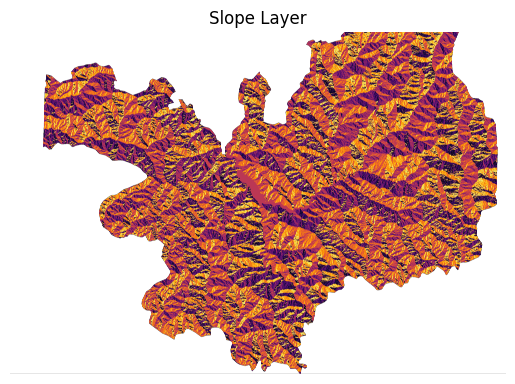

In [15]:
import matplotlib.pyplot as plt

plt.imshow(stack[1], cmap="inferno")
plt.title("Slope Layer")
plt.axis("off")
plt.show()

Feature Stack Info:
CRS: EPSG:32644
Shape (bands, height, width): (5, 7222, 10476)
Resolution: 10.0 meters

===== Elevation (Band 1) =====
Min: -9998.994140625
Max: 4770.96142578125
Mean: 1730.327355776377
-------------------------------


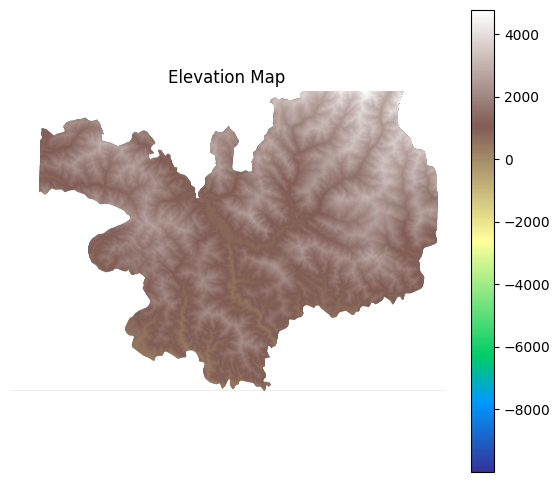

===== Slope (Band 2) =====
Min: 0.0
Max: 359.2785339355469
Mean: 182.90824676181305
-------------------------------


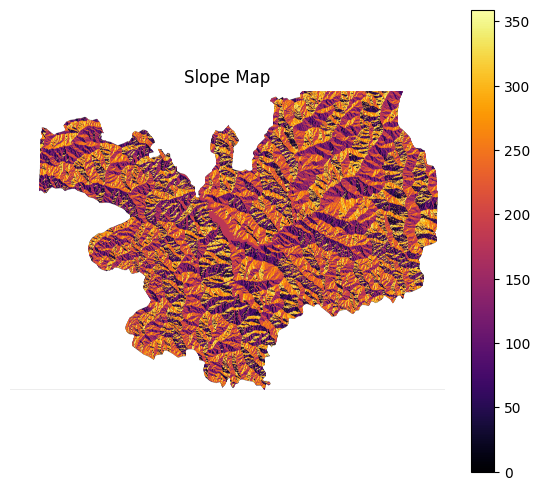

===== Aspect (Band 3) =====
Min: 0.0
Max: 359.2785339355469
Mean: 182.90824676181305
-------------------------------


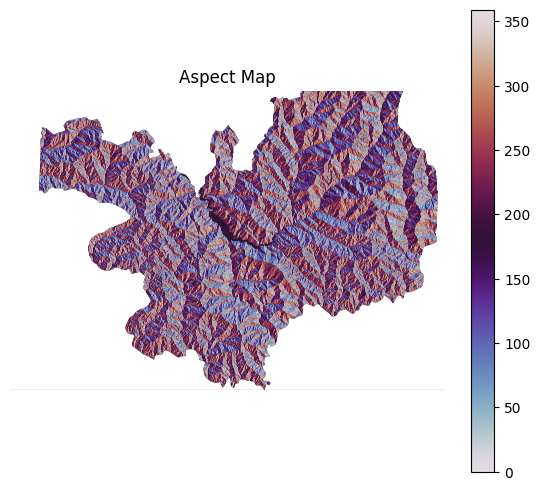

===== NDVI (Band 4) =====
Min: -1.0
Max: 1.0
Mean: 0.3216365927635702
-------------------------------


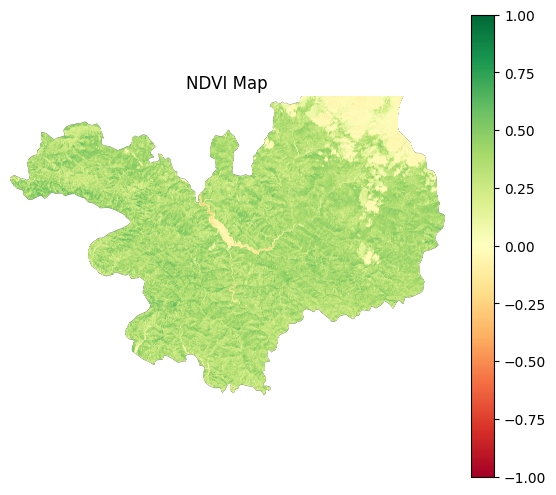

===== NDWI (Band 5) =====
Min: -1.0
Max: 1.0
Mean: -0.3278953798128259
-------------------------------


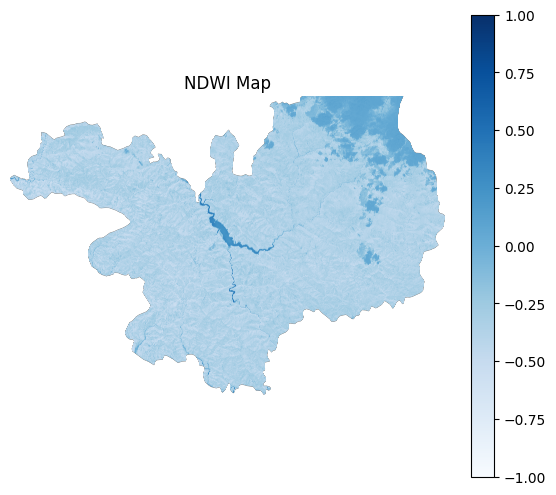

In [17]:
stack_path = "tehri_landslide/data/feature_stack.tif"

band_names = ["Elevation", "Slope", "Aspect", "NDVI", "NDWI"]

with rasterio.open(stack_path) as src:
    print("Feature Stack Info:")
    print("CRS:", src.crs)
    print("Shape (bands, height, width):", (src.count, src.height, src.width))
    print("Resolution:", src.transform.a, "meters\n")

    for i in range(1, src.count + 1):
        arr = src.read(i).astype(float)
        arr[arr <= -9999] = np.nan   # clean nodata

        name = band_names[i-1]
        print(f"===== {name} (Band {i}) =====")
        print("Min:", np.nanmin(arr))
        print("Max:", np.nanmax(arr))
        print("Mean:", np.nanmean(arr))
        print("-------------------------------")

        # Visualization
        cmap = "terrain" if name=="Elevation" else \
               "inferno" if name=="Slope" else \
               "twilight" if name=="Aspect" else \
               "RdYlGn" if name=="NDVI" else \
               "Blues"

        plt.figure(figsize=(7,6))
        plt.imshow(arr, cmap=cmap)
        plt.title(f"{name} Map")
        plt.colorbar()
        plt.axis("off")
        plt.show()